# PFAM Classification Task

**Aim:**
- Classify protein family from amino acid sequence

**Overview:**
- Explore the dataset
    - Examine class distributions and other key statistics
    - Deal with class imbalance, and large size
- Define hypothesis
    - Can BERT-style embeddings enable few shot learning?
- Define method
- Define experiments
- Define model
    - Transformer
    - ProtCNN as baseline (can change to MLP)
- Train
- Results

## Imports

In [26]:
import pandas as pd
import glob

## Exploratory data analysis

### Load data
We first read in the train, val, test data to `pandas` dataframes

In [27]:
# Set filepaths to train, val, test splits
train_path = "data/train"
dev_path = "data/dev"
test_path = "data/test"

# Initialize the dataframes
train_df = pd.DataFrame()
dev_df = pd.DataFrame()
test_df = pd.DataFrame()

# Read in data
for filepath in glob.iglob(train_path + "/*"):
    train_df = pd.concat([train_df, pd.read_csv(filepath)], axis=0)
for filepath in glob.iglob(dev_path + "/*"):
    dev_df = pd.concat([dev_df, pd.read_csv(filepath)], axis=0)
for filepath in glob.iglob(test_path + "/*"):
    test_df = pd.concat([test_df, pd.read_csv(filepath)], axis=0)

In [28]:
train_df

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,EKR,R6QAS0_9FIRM/627-685,PF10371.9,.EEKKLVIPTNRPEMKDFVKNILHPIDHLHGDDLPVSKFV..DRAD...,EEKKLVIPTNRPEMKDFVKNILHPIDHLHGDDLPVSKFVDRADGVY...
1,DUF4042,B3MYB3_DROAN/365-542,PF13251.6,KVRISALHLLGSLAKNLPRRFLYGYWHILFPSG.......EHGATN...,KVRISALHLLGSLAKNLPRRFLYGYWHILFPSGEHGATNSHLLLLG...
2,Reg_prop,Q8EJN6_SHEON/296-320,PF07494.11,AQANMETLK..AILF...DKSG.LMWVGGSG,AQANMETLKAILFDKSGLMWVGGSG
3,DUF3880,M1WYU2_PSEP2/257-334,PF12996.7,WFVDNPHLILHHYTHPGTDNTAIFTYDAGNL.EPLRRKGFANTY.Y...,WFVDNPHLILHHYTHPGTDNTAIFTYDAGNLEPLRRKGFANTYYLP...
4,UPRTase,B6GYG1_PENRW/502-699,PF14681.6,AT.DRPAAKLLMTPMRDASI.SGSALRKVHGRVGFYLATELCT.QI...,ATDRPAAKLLMTPMRDASISGSALRKVHGRVGFYLATELCTQIMGL...
...,...,...,...,...,...
13370,Tub_N,F1RNI1_PIG/29-238,PF16322.5,RQRALLEQKQKKKRQEPL.MVQANADGR..PRSRRARQSE.........,RQRALLEQKQKKKRQEPLMVQANADGRPRSRRARQSEEQAPLVESY...
13371,Phospho_p8,A0A1X7VUV4_AMPQE/3-63,PF10195.9,HIYFDEYDY.FNFGSGFDKMFPDNKNTGHSKHKGYKLETQRYSPSG...,HIYFDEYDYFNFGSGFDKMFPDNKNTGHSKHKGYKLETQRYSPSGH...
13372,E3_binding,D5QEH1_KOMHA/126-161,PF02817.17,VFASPVAR.RLARLHEL....DLR..RV..G....G....S.GPRG...,VFASPVARRLARLHELDLRRVGGSGPRGRILRRDIE
13373,CDT1,W5MBI2_LEPOC/258-422,PF08839.11,LPYKYKMLAEMFRCLDTIVSILFNRSETATFAK.VKQGVQDMMH.....,LPYKYKMLAEMFRCLDTIVSILFNRSETATFAKVKQGVQDMMHKRF...


Note: Sequences are aligned to their family. However we are predicting the family, i.e. this is unknown.<br><br>
$\therefore$ we should not use `aligned_sequences`

In [29]:
all_dfs = [train_df, dev_df, test_df]

In [30]:
for df in all_dfs:
    df.drop(columns=["aligned_sequence"], inplace=True)
    print(df.columns)

Index(['family_id', 'sequence_name', 'family_accession', 'sequence'], dtype='object')
Index(['family_id', 'sequence_name', 'family_accession', 'sequence'], dtype='object')
Index(['family_id', 'sequence_name', 'family_accession', 'sequence'], dtype='object')


Also, version number is irrelevant in `family_accession`. <br><br>
$\therefore$ we drop them.

In [43]:
for df in all_dfs:
    df["family_accession"] = df["family_accession"].apply(lambda x: x.split(".")[0])
train_df

,family_id,sequence_name,family_accession,sequence
0,EKR,R6QAS0_9FIRM/627-685,PF10371,EEKKLVIPTNRPEMKDFVKNILHPIDHLHGDDLPVSKFVDRADGVY...
1,DUF4042,B3MYB3_DROAN/365-542,PF13251,KVRISALHLLGSLAKNLPRRFLYGYWHILFPSGEHGATNSHLLLLG...
2,Reg_prop,Q8EJN6_SHEON/296-320,PF07494,AQANMETLKAILFDKSGLMWVGGSG
3,DUF3880,M1WYU2_PSEP2/257-334,PF12996,WFVDNPHLILHHYTHPGTDNTAIFTYDAGNLEPLRRKGFANTYYLP...
4,UPRTase,B6GYG1_PENRW/502-699,PF14681,ATDRPAAKLLMTPMRDASISGSALRKVHGRVGFYLATELCTQIMGL...
...,...,...,...,...
13370,Tub_N,F1RNI1_PIG/29-238,PF16322,RQRALLEQKQKKKRQEPLMVQANADGRPRSRRARQSEEQAPLVESY...
13371,Phospho_p8,A0A1X7VUV4_AMPQE/3-63,PF10195,HIYFDEYDYFNFGSGFDKMFPDNKNTGHSKHKGYKLETQRYSPSGH...
13372,E3_binding,D5QEH1_KOMHA/126-161,PF02817,VFASPVARRLARLHELDLRRVGGSGPRGRILRRDIE
13373,CDT1,W5MBI2_LEPOC/258-422,PF08839,LPYKYKMLAEMFRCLDTIVSILFNRSETATFAKVKQGVQDMMHKRF...


### Key statistics

#### Dataset split

In [44]:
n_train = train_df.shape[0]
n_dev = dev_df.shape[0]
n_test = test_df.shape[0]
n_total = n_train + n_dev + n_test
print(f"Train: {n_train} ({n_train/n_total*100:.1f}%)")
print(f"Dev: {n_dev} ({n_dev/n_total*100:.1f}%)")
print(f"Test: {n_test} ({n_test/n_total*100:.1f}%)")

Train: 1086741 (81.2%)
Dev: 126171 (9.4%)
Test: 126171 (9.4%)


Large proportion of data is in training set

#### Class distribution

In [45]:
for df, split in zip(all_dfs, ["train", "dev", "test"]):
    print(f"The number of unique families in {split} set is {len(df['family_accession'].unique())}")

The number of unique families in train set is 17929
The number of unique families in dev set is 13071
The number of unique families in test set is 13071


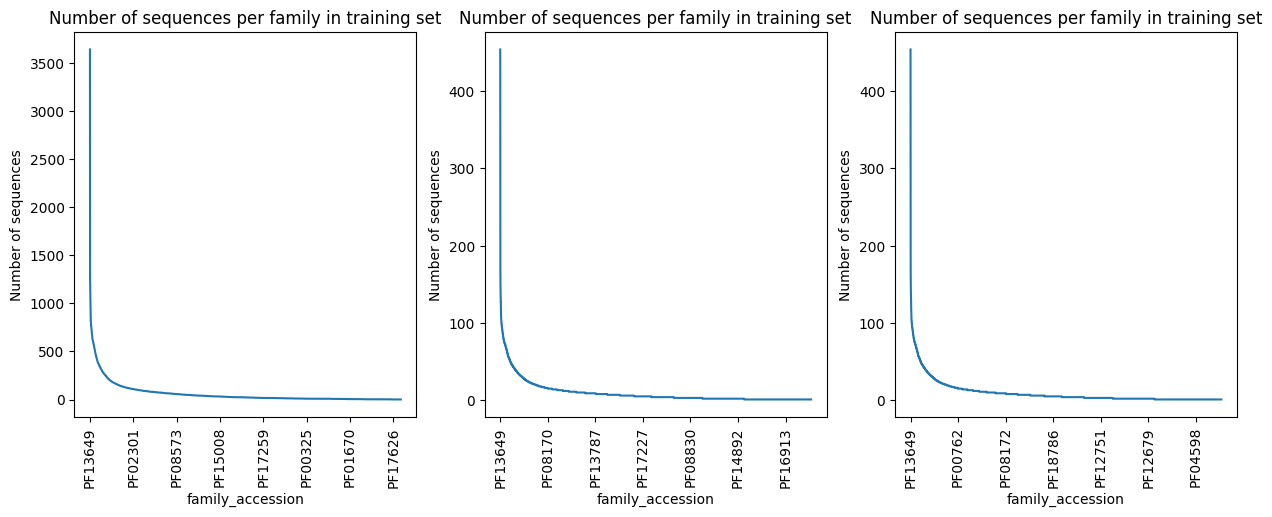

In [52]:
import matplotlib.pyplot as plt

def plot_class_freqs(df):
    class_freqs = df["family_accession"].value_counts()
    class_freqs.plot(rot=90)
    plt.ylabel("Number of sequences")
    plt.title("Number of sequences per family in training set")

plt.subplots(1,3, figsize=(15,5))
for i, df in enumerate(all_dfs):
    plt.subplot(1,3,i+1)
    plot_class_freqs(df)